In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from geopy.distance import great_circle
from datasist.structdata import detect_outliers
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [2]:
df = pd.read_csv("uber.csv")
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [3]:
df.shape

(200000, 9)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [5]:
df.drop(['Unnamed: 0','key'],axis=1,inplace=True)

In [6]:
df.describe()[['fare_amount','passenger_count']]

,fare_amount,passenger_count
count,200000.000000,200000.000000
mean,11.359955,1.684535
std,9.901776,1.385997
min,-52.000000,0.000000
25%,6.000000,1.000000
50%,8.500000,1.000000
75%,12.500000,2.000000
max,499.000000,208.000000


In [7]:
df[df['fare_amount'] < 0].shape

(17, 7)

In [8]:
Wrongindices = []

Wrongindices = list(df[df['fare_amount']<0].index)
len(Wrongindices), len(set(Wrongindices))

(17, 17)

In [9]:
df.drop(Wrongindices,axis=0,inplace=True)
df.reset_index(inplace=True)
df.drop(['index'],axis = 1,inplace=True)
df.shape

(199983, 7)

In [10]:
df.describe()[['fare_amount','passenger_count']]

,fare_amount,passenger_count
count,199983.000000,199983.000000
mean,11.362365,1.684493
std,9.897119,1.385979
min,0.000000,0.000000
25%,6.000000,1.000000
50%,8.500000,1.000000
75%,12.500000,2.000000
max,499.000000,208.000000


In [11]:
df[df['passenger_count']>6]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
113030,11.7,2010-12-28 08:20:00 UTC,-73.937795,40.758498,-73.937835,40.758415,208


In [12]:
df.drop(113030, axis=0, inplace=True)

In [13]:
df.describe()[['fare_amount','passenger_count']]

,fare_amount,passenger_count
count,199982.000000,199982.000000
mean,11.362364,1.683462
std,9.897143,1.306941
min,0.000000,0.000000
25%,6.000000,1.000000
50%,8.500000,1.000000
75%,12.500000,2.000000
max,499.000000,6.000000


In [14]:
df.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count'],
      dtype='object')

In [15]:
df[['pickup_datetime']]

,pickup_datetime
0,2015-05-07 19:52:06 UTC
1,2009-07-17 20:04:56 UTC
2,2009-08-24 21:45:00 UTC
3,2009-06-26 08:22:21 UTC
4,2014-08-28 17:47:00 UTC
...,...
199978,2012-10-28 10:49:00 UTC
199979,2014-03-14 01:09:00 UTC
199980,2009-06-29 00:42:00 UTC
199981,2015-05-20 14:56:25 UTC


In [16]:
df['pickup_datetime'].unique()

array(['2015-05-07 19:52:06 UTC', '2009-07-17 20:04:56 UTC',
       '2009-08-24 21:45:00 UTC', ..., '2009-06-29 00:42:00 UTC',
       '2015-05-20 14:56:25 UTC', '2010-05-15 04:08:00 UTC'], dtype=object)

In [17]:
def extract_utc(x):
    return x.split('UTC')[0]

In [18]:
df['pickup_datetime'] = df['pickup_datetime'].apply(extract_utc)

In [19]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S ', errors='coerce')

In [20]:
df['Year'] = df['pickup_datetime'].dt.year
df['Month'] = df['pickup_datetime'].dt.month
df['Month_Name'] = df['pickup_datetime'].dt.month_name()
df['Week'] = df['pickup_datetime'].dt.week
df['Day'] = df['pickup_datetime'].dt.day
df['Week_Day'] = df['pickup_datetime'].dt.weekday
df['Day_Name'] = df['pickup_datetime'].dt.day_name()
df['Hour'] = df['pickup_datetime'].dt.hour
df['Minute'] = df['pickup_datetime'].dt.minute

In [21]:
def map_months(x):
    if x in [12, 1, 2]:
        return 'Winter'
    elif x in [3, 4, 5]:
        return 'Spring'
    elif x in [6, 7, 8]:
        return 'Summer'
    elif x in [9, 10, 11]:
        return 'Autumn'

def map_hours(x):
    if x in range(0, 13):
        return 'morning'
    elif x in range(13, 19):
        return 'afternoon'
    else:
        return 'evening'

    
df['Season'] = df['Month'].apply(map_months)
    
df['Period'] = df['Hour'].apply(map_hours)
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month,Month_Name,Week,Day,Week_Day,Day_Name,Hour,Minute,Season,Period
0,7.5,2015-05-07 19:52:06,-73.999817,40.738354,-73.999512,40.723217,1,2015,5,May,19,7,3,Thursday,19,52,Spring,evening
1,7.7,2009-07-17 20:04:56,-73.994355,40.728225,-73.994710,40.750325,1,2009,7,July,29,17,4,Friday,20,4,Summer,evening
2,12.9,2009-08-24 21:45:00,-74.005043,40.740770,-73.962565,40.772647,1,2009,8,August,35,24,0,Monday,21,45,Summer,evening
3,5.3,2009-06-26 08:22:21,-73.976124,40.790844,-73.965316,40.803349,3,2009,6,June,26,26,4,Friday,8,22,Summer,morning
4,16.0,2014-08-28 17:47:00,-73.925023,40.744085,-73.973082,40.761247,5,2014,8,August,35,28,3,Thursday,17,47,Summer,afternoon


In [22]:
df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month,Month_Name,Week,Day,Week_Day,Day_Name,Hour,Minute,Season,Period
0,7.5,2015-05-07 19:52:06,-73.999817,40.738354,-73.999512,40.723217,1,2015,5,May,19,7,3,Thursday,19,52,Spring,evening
1,7.7,2009-07-17 20:04:56,-73.994355,40.728225,-73.994710,40.750325,1,2009,7,July,29,17,4,Friday,20,4,Summer,evening
2,12.9,2009-08-24 21:45:00,-74.005043,40.740770,-73.962565,40.772647,1,2009,8,August,35,24,0,Monday,21,45,Summer,evening
3,5.3,2009-06-26 08:22:21,-73.976124,40.790844,-73.965316,40.803349,3,2009,6,June,26,26,4,Friday,8,22,Summer,morning
4,16.0,2014-08-28 17:47:00,-73.925023,40.744085,-73.973082,40.761247,5,2014,8,August,35,28,3,Thursday,17,47,Summer,afternoon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199978,3.0,2012-10-28 10:49:00,-73.987042,40.739367,-73.986525,40.740297,1,2012,10,October,43,28,6,Sunday,10,49,Autumn,morning
199979,7.5,2014-03-14 01:09:00,-73.984722,40.736837,-74.006672,40.739620,1,2014,3,March,11,14,4,Friday,1,9,Spring,morning
199980,30.9,2009-06-29 00:42:00,-73.986017,40.756487,-73.858957,40.692588,2,2009,6,June,27,29,0,Monday,0,42,Summer,morning
199981,14.5,2015-05-20 14:56:25,-73.997124,40.725452,-73.983215,40.695415,1,2015,5,May,21,20,2,Wednesday,14,56,Spring,afternoon


In [23]:
df.isna().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
Year                 0
Month                0
Month_Name           0
Week                 0
Day                  0
Week_Day             0
Day_Name             0
Hour                 0
Minute               0
Season               0
Period               0
dtype: int64

In [24]:
df[df['dropoff_longitude'].isna()]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month,Month_Name,Week,Day,Week_Day,Day_Name,Hour,Minute,Season,Period
87943,24.1,2013-07-02 03:51:57,-73.950581,40.779692,NaN,NaN,0,2013,7,July,27,2,1,Tuesday,3,51,Summer,morning


In [25]:
df.dropna(inplace=True)

In [26]:
df.isna().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
Year                 0
Month                0
Month_Name           0
Week                 0
Day                  0
Week_Day             0
Day_Name             0
Hour                 0
Minute               0
Season               0
Period               0
dtype: int64

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199981 entries, 0 to 199982
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   fare_amount        199981 non-null  float64       
 1   pickup_datetime    199981 non-null  datetime64[ns]
 2   pickup_longitude   199981 non-null  float64       
 3   pickup_latitude    199981 non-null  float64       
 4   dropoff_longitude  199981 non-null  float64       
 5   dropoff_latitude   199981 non-null  float64       
 6   passenger_count    199981 non-null  int64         
 7   Year               199981 non-null  int64         
 8   Month              199981 non-null  int64         
 9   Month_Name         199981 non-null  object        
 10  Week               199981 non-null  int64         
 11  Day                199981 non-null  int64         
 12  Week_Day           199981 non-null  int64         
 13  Day_Name           199981 non-null  object  

In [28]:
df[df['pickup_latitude'] > 90].index

Int64Index([56617, 61793, 75849, 91418], dtype='int64')

In [29]:
df[df['pickup_latitude'] < -90].index

Int64Index([], dtype='int64')

In [30]:
Wrongindices = []

Wrongindices = list(df[df['dropoff_latitude'] > 90].index)
Wrongindices.extend(df[df['dropoff_latitude'] < -90].index)
Wrongindices.extend(df[df['pickup_latitude'] > 90].index)
Wrongindices.extend(df[df['pickup_latitude'] < -90].index)
len(Wrongindices), len(set(Wrongindices))

(7, 5)

In [31]:
df.drop(Wrongindices,axis=0,inplace=True)
df.reset_index(inplace=True)
df.drop(['index'],axis = 1,inplace=True)
df.shape

(199976, 18)

In [32]:
df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month,Month_Name,Week,Day,Week_Day,Day_Name,Hour,Minute,Season,Period
0,7.5,2015-05-07 19:52:06,-73.999817,40.738354,-73.999512,40.723217,1,2015,5,May,19,7,3,Thursday,19,52,Spring,evening
1,7.7,2009-07-17 20:04:56,-73.994355,40.728225,-73.994710,40.750325,1,2009,7,July,29,17,4,Friday,20,4,Summer,evening
2,12.9,2009-08-24 21:45:00,-74.005043,40.740770,-73.962565,40.772647,1,2009,8,August,35,24,0,Monday,21,45,Summer,evening
3,5.3,2009-06-26 08:22:21,-73.976124,40.790844,-73.965316,40.803349,3,2009,6,June,26,26,4,Friday,8,22,Summer,morning
4,16.0,2014-08-28 17:47:00,-73.925023,40.744085,-73.973082,40.761247,5,2014,8,August,35,28,3,Thursday,17,47,Summer,afternoon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199971,3.0,2012-10-28 10:49:00,-73.987042,40.739367,-73.986525,40.740297,1,2012,10,October,43,28,6,Sunday,10,49,Autumn,morning
199972,7.5,2014-03-14 01:09:00,-73.984722,40.736837,-74.006672,40.739620,1,2014,3,March,11,14,4,Friday,1,9,Spring,morning
199973,30.9,2009-06-29 00:42:00,-73.986017,40.756487,-73.858957,40.692588,2,2009,6,June,27,29,0,Monday,0,42,Summer,morning
199974,14.5,2015-05-20 14:56:25,-73.997124,40.725452,-73.983215,40.695415,1,2015,5,May,21,20,2,Wednesday,14,56,Spring,afternoon


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199976 entries, 0 to 199975
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   fare_amount        199976 non-null  float64       
 1   pickup_datetime    199976 non-null  datetime64[ns]
 2   pickup_longitude   199976 non-null  float64       
 3   pickup_latitude    199976 non-null  float64       
 4   dropoff_longitude  199976 non-null  float64       
 5   dropoff_latitude   199976 non-null  float64       
 6   passenger_count    199976 non-null  int64         
 7   Year               199976 non-null  int64         
 8   Month              199976 non-null  int64         
 9   Month_Name         199976 non-null  object        
 10  Week               199976 non-null  int64         
 11  Day                199976 non-null  int64         
 12  Week_Day           199976 non-null  int64         
 13  Day_Name           199976 non-null  object  

In [34]:
df.duplicated().sum()

0

In [35]:
def fare_amountLevel(x) : 
    x = int(x)
    if x < 20 : 
        return 'Cheap'
    elif  x <50 : 
        return 'Medium'
    else :
        return 'Expensive'
df['fare_amountLevel'] =df['fare_amount'] .apply(lambda x : fare_amountLevel(x))
df['fare_amountLevel'].value_counts()

Cheap        179010
Medium        18316
Expensive      2650
Name: fare_amountLevel, dtype: int64

In [36]:
df.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'Year',
       'Month', 'Month_Name', 'Week', 'Day', 'Week_Day', 'Day_Name', 'Hour',
       'Minute', 'Season', 'Period', 'fare_amountLevel'],
      dtype='object')

In [37]:
def get_dist(x):
    loc_1 = (x['pickup_latitude'], x['pickup_longitude'])
    loc_2 = (x['dropoff_latitude'], x['dropoff_longitude'])
    return great_circle(loc_1, loc_2).kilometers

df['Destination_Km'] = df.apply(get_dist, axis=1)
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month,Month_Name,Week,Day,Week_Day,Day_Name,Hour,Minute,Season,Period,fare_amountLevel,Destination_Km
0,7.5,2015-05-07 19:52:06,-73.999817,40.738354,-73.999512,40.723217,1,2015,5,May,19,7,3,Thursday,19,52,Spring,evening,Cheap,1.683325
1,7.7,2009-07-17 20:04:56,-73.994355,40.728225,-73.994710,40.750325,1,2009,7,July,29,17,4,Friday,20,4,Summer,evening,Cheap,2.457593
2,12.9,2009-08-24 21:45:00,-74.005043,40.740770,-73.962565,40.772647,1,2009,8,August,35,24,0,Monday,21,45,Summer,evening,Cheap,5.036384
3,5.3,2009-06-26 08:22:21,-73.976124,40.790844,-73.965316,40.803349,3,2009,6,June,26,26,4,Friday,8,22,Summer,morning,Cheap,1.661686
4,16.0,2014-08-28 17:47:00,-73.925023,40.744085,-73.973082,40.761247,5,2014,8,August,35,28,3,Thursday,17,47,Summer,afternoon,Cheap,4.475456


# Data Visualization

<AxesSubplot:xlabel='fare_amount', ylabel='Density'>

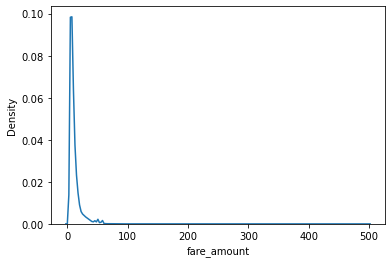

In [38]:
sns.kdeplot(data = df, x='fare_amount')

<AxesSubplot:xlabel='passenger_count', ylabel='Density'>

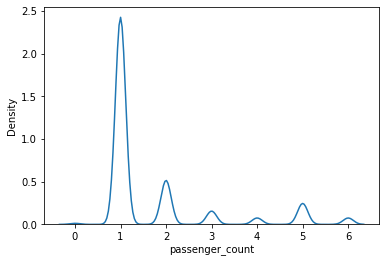

In [39]:
sns.kdeplot(data = df, x='passenger_count')

<AxesSubplot:xlabel='Destination_Km', ylabel='Density'>

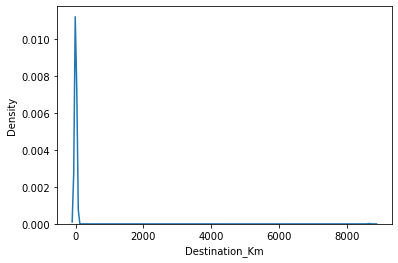

In [40]:
sns.kdeplot(data = df, x='Destination_Km')

In [42]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month,Month_Name,Week,Day,Week_Day,Day_Name,Hour,Minute,Season,Period,fare_amountLevel,Destination_Km
0,7.5,2015-05-07 19:52:06,-73.999817,40.738354,-73.999512,40.723217,1,2015,5,May,19,7,3,Thursday,19,52,Spring,evening,Cheap,1.683325
1,7.7,2009-07-17 20:04:56,-73.994355,40.728225,-73.994710,40.750325,1,2009,7,July,29,17,4,Friday,20,4,Summer,evening,Cheap,2.457593
2,12.9,2009-08-24 21:45:00,-74.005043,40.740770,-73.962565,40.772647,1,2009,8,August,35,24,0,Monday,21,45,Summer,evening,Cheap,5.036384
3,5.3,2009-06-26 08:22:21,-73.976124,40.790844,-73.965316,40.803349,3,2009,6,June,26,26,4,Friday,8,22,Summer,morning,Cheap,1.661686
4,16.0,2014-08-28 17:47:00,-73.925023,40.744085,-73.973082,40.761247,5,2014,8,August,35,28,3,Thursday,17,47,Summer,afternoon,Cheap,4.475456


<AxesSubplot:xlabel='passenger_count', ylabel='count'>

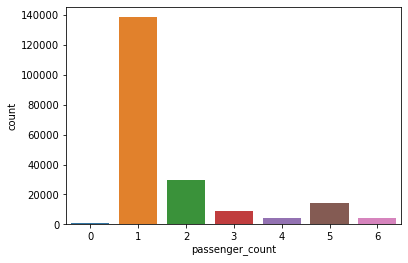

In [43]:
sns.countplot(data=df,x='passenger_count')

<AxesSubplot:xlabel='Year', ylabel='count'>

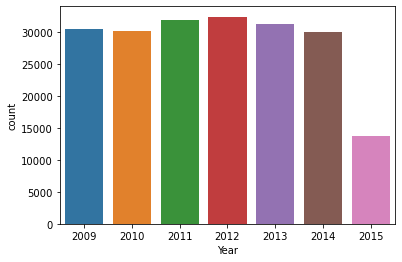

In [44]:
sns.countplot(data=df,x='Year')

<AxesSubplot:xlabel='count', ylabel='Month_Name'>

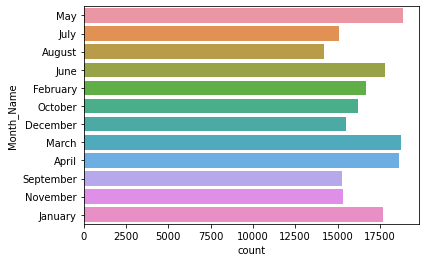

In [68]:
sns.countplot(data=df,y='Month_Name')

<AxesSubplot:xlabel='Day_Name', ylabel='count'>

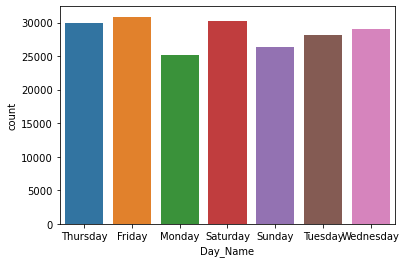

In [46]:
sns.countplot(data=df,x='Day_Name')

<AxesSubplot:xlabel='Season', ylabel='count'>

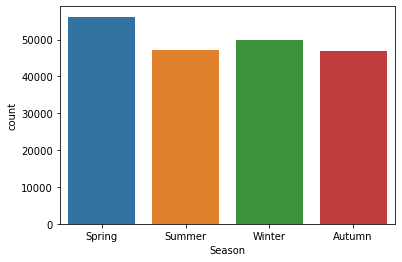

In [47]:
sns.countplot(data=df,x='Season')

<AxesSubplot:xlabel='Period', ylabel='count'>

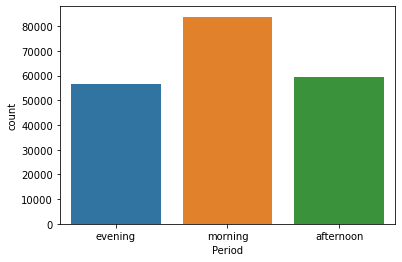

In [48]:
sns.countplot(data=df,x='Period')

<AxesSubplot:xlabel='fare_amountLevel', ylabel='count'>

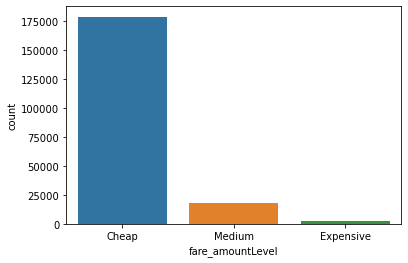

In [49]:
sns.countplot(data=df,x='fare_amountLevel')

<AxesSubplot:xlabel='Day_Name', ylabel='fare_amount'>

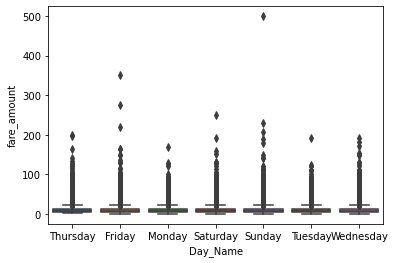

In [69]:
sns.boxplot(data=df,y='fare_amount',x='Day_Name')

<AxesSubplot:xlabel='Year', ylabel='fare_amount'>

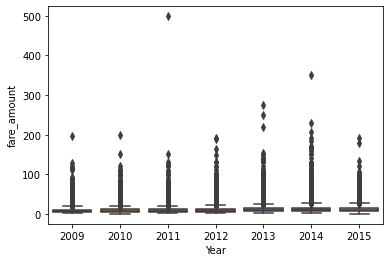

In [70]:
sns.boxplot(data=df,y='fare_amount',x='Year')

In [72]:
def Pie(data,feature,Limit=20) : 
    fig, ax = plt.subplots(figsize=(10,6))
    plt.pie(data[feature].value_counts()[:Limit],labels=list(
        data[feature].value_counts()[:Limit].index),
        autopct ='%1.2f%%' , labeldistance = 1.1,
            explode = [0.05 for i in range(len(data[feature].value_counts()[:Limit]))] )
    plt.show()    

In [74]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month,Month_Name,Week,Day,Week_Day,Day_Name,Hour,Minute,Season,Period,fare_amountLevel,Destination_Km,Day_NameEnc,SeasonEnc,PeriodEnc
0,7.5,2015-05-07 19:52:06,-73.999817,40.738354,-73.999512,40.723217,1,2015,5,May,19,7,3,Thursday,19,52,Spring,evening,Cheap,1.683325,4,1,1
1,7.7,2009-07-17 20:04:56,-73.994355,40.728225,-73.994710,40.750325,1,2009,7,July,29,17,4,Friday,20,4,Summer,evening,Cheap,2.457593,0,2,1
2,12.9,2009-08-24 21:45:00,-74.005043,40.740770,-73.962565,40.772647,1,2009,8,August,35,24,0,Monday,21,45,Summer,evening,Cheap,5.036384,1,2,1
3,5.3,2009-06-26 08:22:21,-73.976124,40.790844,-73.965316,40.803349,3,2009,6,June,26,26,4,Friday,8,22,Summer,morning,Cheap,1.661686,0,2,2
4,16.0,2014-08-28 17:47:00,-73.925023,40.744085,-73.973082,40.761247,5,2014,8,August,35,28,3,Thursday,17,47,Summer,afternoon,Cheap,4.475456,4,2,0


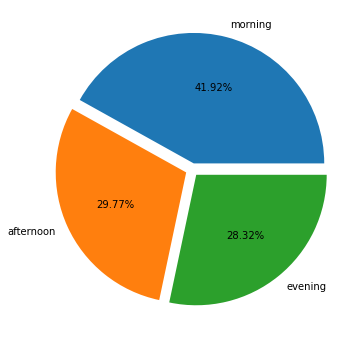

In [79]:
Pie(df,'Period')

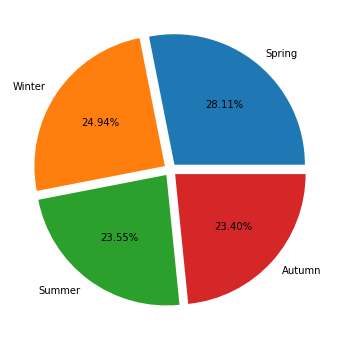

In [81]:
Pie(df,'Season')

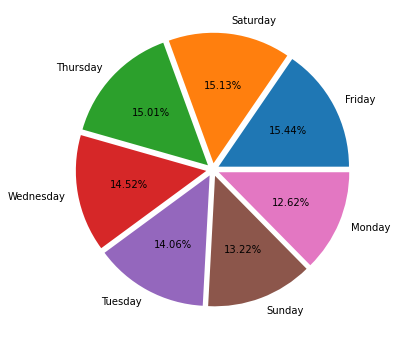

In [82]:
Pie(df,'Day_Name')

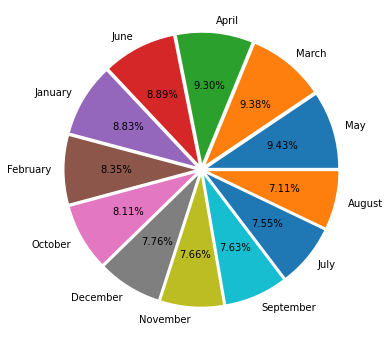

In [83]:
Pie(df,'Month_Name')

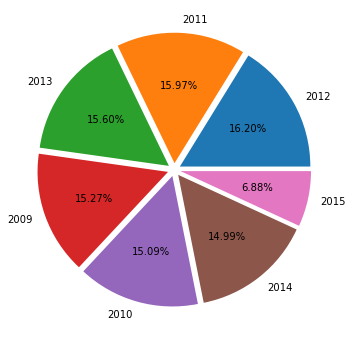

In [76]:
Pie(df,'Year')

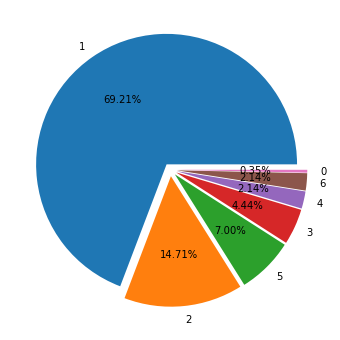

In [75]:
Pie(df,'passenger_count')

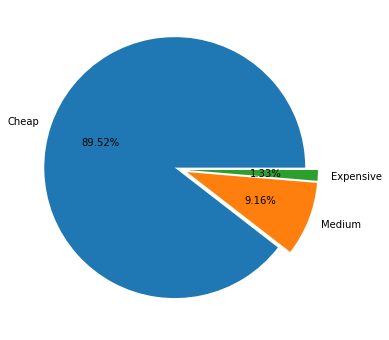

In [73]:
Pie(df,'fare_amountLevel')

# Prepare for model

In [52]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month,Month_Name,Week,Day,Week_Day,Day_Name,Hour,Minute,Season,Period,fare_amountLevel,Destination_Km
0,7.5,2015-05-07 19:52:06,-73.999817,40.738354,-73.999512,40.723217,1,2015,5,May,19,7,3,Thursday,19,52,Spring,evening,Cheap,1.683325
1,7.7,2009-07-17 20:04:56,-73.994355,40.728225,-73.994710,40.750325,1,2009,7,July,29,17,4,Friday,20,4,Summer,evening,Cheap,2.457593
2,12.9,2009-08-24 21:45:00,-74.005043,40.740770,-73.962565,40.772647,1,2009,8,August,35,24,0,Monday,21,45,Summer,evening,Cheap,5.036384
3,5.3,2009-06-26 08:22:21,-73.976124,40.790844,-73.965316,40.803349,3,2009,6,June,26,26,4,Friday,8,22,Summer,morning,Cheap,1.661686
4,16.0,2014-08-28 17:47:00,-73.925023,40.744085,-73.973082,40.761247,5,2014,8,August,35,28,3,Thursday,17,47,Summer,afternoon,Cheap,4.475456


In [53]:
df[df['fare_amount'] > 50]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month,Month_Name,Week,Day,Week_Day,Day_Name,Hour,Minute,Season,Period,fare_amountLevel,Destination_Km
48,56.80,2013-01-03 22:24:41,-73.993498,40.764686,-73.993498,40.764686,1,2013,1,January,1,3,3,Thursday,22,24,Winter,evening,Expensive,0.000000
401,57.33,2014-06-27 14:12:49,-73.776736,40.645518,-73.994633,40.719009,1,2014,6,June,26,27,4,Friday,14,12,Summer,afternoon,Expensive,20.109066
570,57.33,2013-09-23 09:07:18,-73.991220,40.754664,-73.776311,40.645212,1,2013,9,September,39,23,0,Monday,9,7,Autumn,morning,Expensive,21.825389
610,57.33,2013-09-16 16:02:08,-73.992281,40.765674,-73.789631,40.647025,1,2013,9,September,38,16,0,Monday,16,2,Autumn,afternoon,Expensive,21.583606
747,52.00,2013-01-26 14:20:18,-73.993418,40.720149,-73.789199,40.641738,1,2013,1,January,4,26,5,Saturday,14,20,Winter,afternoon,Expensive,19.302164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199645,52.00,2013-09-20 14:15:00,0.000000,0.000000,0.000000,0.000000,1,2013,9,September,38,20,4,Friday,14,15,Autumn,afternoon,Expensive,0.000000
199651,53.30,2012-01-27 16:36:00,-73.953060,40.774205,-73.951238,40.773545,5,2012,1,January,4,27,4,Friday,16,36,Winter,afternoon,Expensive,0.170074
199686,57.33,2014-07-25 21:46:01,-73.784489,40.648543,-73.984224,40.727088,1,2014,7,July,30,25,4,Friday,21,46,Summer,evening,Expensive,18.970906
199890,57.33,2014-11-14 05:25:00,-73.776778,40.645427,-73.948572,40.789107,5,2014,11,November,46,14,4,Friday,5,25,Autumn,morning,Expensive,21.561049


In [54]:
Day_NameEnc,SeasonEnc,PeriodEnc,fare_amountLevelEnc = LabelEncoder(),LabelEncoder(),LabelEncoder(),LabelEncoder()

In [55]:
def ApplyEncoder(Encoder,OriginalColumn) : 
    global df
    Encoder.fit(df[OriginalColumn])
    return Encoder.transform(df[OriginalColumn])

In [56]:
df['Day_NameEnc'] = ApplyEncoder(Day_NameEnc,'Day_Name')
df['SeasonEnc'] = ApplyEncoder(SeasonEnc,'Season')
df['PeriodEnc'] = ApplyEncoder(PeriodEnc,'Period')
#df['fare_amountLevelEnc'] = ApplyEncoder(fare_amountLevelEnc,'fare_amountLevel')

# splitting data

In [57]:
df.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'Year',
       'Month', 'Month_Name', 'Week', 'Day', 'Week_Day', 'Day_Name', 'Hour',
       'Minute', 'Season', 'Period', 'fare_amountLevel', 'Destination_Km',
       'Day_NameEnc', 'SeasonEnc', 'PeriodEnc'],
      dtype='object')

In [58]:
x = df[[ 'passenger_count', 'Year',
       'Month', 'Week', 'Day', 'Week_Day', 'Hour',
       'Minute', 'Destination_Km',
       'Day_NameEnc', 'SeasonEnc', 'PeriodEnc']]
y=df['fare_amount']

In [59]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.05 , random_state = 44 , shuffle = True)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((189977, 12), (9999, 12), (189977,), (9999,))

In [60]:
scaler = StandardScaler()

scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [61]:
# models = {
#     'LR': LinearRegression(),
#     'DT': DecisionTreeRegressor(),
#     'KNN': KNeighborsRegressor(),
# #     'SVM': SVR(), 
#     'RF': RandomForestRegressor(),
#     'XGB': XGBRegressor()
# }

# for name, model in models.items():
#     print(f'Traing {name}...')
#     model.fit(x_train, y_train)
#     y_pred = model.predict(x_test)
#     y_pred_tr = model.predict(x_train)
#     print(f'Training RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_tr))}')
#     print(f'Training MAE: {mean_absolute_error(y_train, y_pred_tr)}')
#     print(f'Training R2: {r2_score(y_train, y_pred_tr)}')
#     print('++++++')
#     print(f'Testing RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
#     print(f'Testing MAE: {mean_absolute_error(y_test, y_pred)}')
#     print(f'Testing R2: {r2_score(y_test, y_pred)}')
#     print('-'*50)

In [62]:
# model = XGBRegressor()


# parameters = {'nthread':[4],
#               'objective':['reg:linear'],
#               'learning_rate': [.03, 0.05, .07],
#               'max_depth': [5, 6, 7],
#               'min_child_weight': [4],
#               'silent': [1],
#               'subsample': [0.7],
#               'colsample_bytree': [0.7],
#               'n_estimators': [400,500,600]}


# grid_search_model = grid_search = RandomizedSearchCV(estimator=model, param_distributions=parameters,
#                            scoring='accuracy', cv=10)

# grid_search_model.fit(x, y)

In [63]:
x = df[[ 'passenger_count', 'Year',
       'Month', 'Week', 'Day', 'Week_Day', 'Hour',
       'Minute', 'Destination_Km',
       'Day_NameEnc', 'SeasonEnc', 'PeriodEnc']]
y=df['fare_amountLevel']


x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.05 , random_state = 44 , shuffle = True)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((189977, 12), (9999, 12), (189977,), (9999,))

In [64]:
# scaler = StandardScaler()

# scaler.fit(x_train)

# x_train = scaler.transform(x_train)
# x_test = scaler.transform(x_test)

In [65]:
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report, f1_score, fbeta_score

In [66]:
GaussianNBModel = GaussianNB()
MultinomialNBModel = MultinomialNB(alpha=1.0)
BernoulliNBModel = BernoulliNB(alpha=1.0,binarize=1)
LogisticRegressionModel = LogisticRegression(penalty='l2',solver='sag',C=1.0,random_state=33)
SGDClassifierModel = SGDClassifier(penalty='l2',loss='squared_loss',learning_rate='optimal',random_state=33)
RandomForestClassifierModel = RandomForestClassifier(criterion = 'gini',n_estimators=300,max_depth=7,random_state=33) 
GBCModel = GradientBoostingClassifier(n_estimators=100,max_depth=3,random_state=33) 
QDAModel = QuadraticDiscriminantAnalysis(tol=0.0001)
SVCModel = SVC(kernel= 'rbf',max_iter=100,C=1.0,gamma='auto')
DecisionTreeClassifierModel = DecisionTreeClassifier(criterion='gini',max_depth=3,random_state=33)
KNNClassifierModel = KNeighborsClassifier(n_neighbors= 5,weights ='uniform',algorithm='auto') 

Models = [GaussianNBModel,KNNClassifierModel,MultinomialNBModel,
          BernoulliNBModel,LogisticRegressionModel,RandomForestClassifierModel,
          GBCModel,SGDClassifierModel,QDAModel,SVCModel,DecisionTreeClassifierModel]

In [67]:
ModelsScore = {}
for Model in Models : 
    print(f'for Model {str(Model).split("(")[0]}')
    Model.fit(x_train, y_train)
    print(f'Train Score is : {Model.score(x_train, y_train)}')
    print(f'Test Score is : {Model.score(x_test, y_test)}')
    y_pred = Model.predict(x_test)
    ClassificationReport = classification_report(y_test,y_pred)
    print('Classification Report is : \n', ClassificationReport )
    print(f'Precision value is  : {ClassificationReport.split()[19]}')
    print(f'Recall value is  : {ClassificationReport.split()[20]}')
    print(f'F1 Score value is  : {ClassificationReport.split()[21]}')
    ModelsScore[str(Model).split("(")[0]] = [ClassificationReport.split()[19],
                                             ClassificationReport.split()[20],ClassificationReport.split()[21]]
    print('=================================================') 

for Model GaussianNB
Train Score is : 0.893692394342473
Test Score is : 0.8917891789178918
Classification Report is : 
               precision    recall  f1-score   support

       Cheap       0.89      1.00      0.94      8929
   Expensive       0.16      0.02      0.03       168
      Medium       0.00      0.00      0.00       902

    accuracy                           0.89      9999
   macro avg       0.35      0.34      0.32      9999
weighted avg       0.80      0.89      0.84      9999

Precision value is  : accuracy
Recall value is  : 0.89
F1 Score value is  : 9999
for Model KNeighborsClassifier
Train Score is : 0.9554051279891776
Test Score is : 0.941994199419942
Classification Report is : 
               precision    recall  f1-score   support

       Cheap       0.96      0.99      0.97      8929
   Expensive       0.62      0.40      0.49       168
      Medium       0.79      0.54      0.64       902

    accuracy                           0.94      9999
   macro avg    